In [1]:
import cv2
import time
import numpy as np
import torch
import random
from torch import Tensor
import json
import os
from os import listdir
from os.path import isfile, join
from torch.nn import BCEWithLogitsLoss
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as xfms
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

In [4]:
torch.cuda.is_available()

True

## Create Dataset

In [5]:
class CCAgT_Dataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)

        image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255.0
        mask = torch.tensor(np.array(mask), dtype=torch.long)

        return image, mask


In [6]:
import os
import random
from sklearn.model_selection import train_test_split

def collect_files(base_dir):
    categories = [d for d in os.listdir(base_dir) 
              if os.path.isdir(os.path.join(base_dir, d))]
    category_files = {category: [] for category in categories}
    
    for category in categories:
        category_path = os.path.join(base_dir, category)
        if os.path.isdir(category_path):
            files = sorted(os.listdir(category_path))
            category_files[category] = [os.path.join(category_path, f) for f in files]
    
    print(f"Found {len(categories)} categories in {base_dir}")
    return category_files

def split_dataset(images_dir, masks_dir, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, seed=42):
    assert train_ratio + val_ratio + test_ratio == 1.0, "比例必須相加等於 1"
    
    image_files = collect_files(images_dir)
    mask_files = collect_files(masks_dir)

    for category in image_files:
        assert len(image_files[category]) == len(mask_files[category]), \
            f"{category} 影像和 mask 數量不一致！"

    split_data = {'train': {'images': [], 'masks': []},
                  'val': {'images': [], 'masks': []},
                  'test': {'images': [], 'masks': []}}

    random.seed(seed)

    for category in image_files:
        imgs = image_files[category]
        masks = mask_files[category]

        # 打亂順序
        combined = list(zip(imgs, masks))
        random.shuffle(combined)
        imgs, masks = zip(*combined)

        train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
            imgs, masks, test_size=(val_ratio + test_ratio), random_state=seed
        )
        val_imgs, test_imgs, val_masks, test_masks = train_test_split(
            temp_imgs, temp_masks, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=seed
        )

        split_data['train']['images'].extend(train_imgs)
        split_data['train']['masks'].extend(train_masks)
        split_data['val']['images'].extend(val_imgs)
        split_data['val']['masks'].extend(val_masks)
        split_data['test']['images'].extend(test_imgs)
        split_data['test']['masks'].extend(test_masks)

    return split_data

images_dir = 'size_512/images_crop'
masks_dir = 'size_512/masks_crop'

split_data = split_dataset(images_dir, masks_dir)

print(f"Train set: {len(split_data['train']['images'])} images")
print(f"Validation set: {len(split_data['val']['images'])} images")
print(f"Test set: {len(split_data['test']['images'])} images")


Found 7 categories in size_512/images_crop
Found 7 categories in size_512/masks_crop
Train set: 14682 images
Validation set: 2097 images
Test set: 4201 images


In [7]:
img_size = [512, 512]
LR = 1e-4
BATCH = 24
EPOCHS = 150

transform = transforms.Compose([transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                              ])

trainset = CCAgT_Dataset(split_data['train']['images'], split_data['train']['masks'])
valset = CCAgT_Dataset(split_data['val']['images'], split_data['val']['masks'])
testset = CCAgT_Dataset(split_data['test']['images'], split_data['test']['masks'])

trainloader = DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=6)
valloader = DataLoader(valset, batch_size=BATCH, shuffle=False, num_workers=6)
testloader = DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=6)

print(f"Training set size: {len(trainset)}")
print(f"Validation set size: {len(valset)}")
print(f"Test set size: {len(testset)}")

Training set size: 14682
Validation set size: 2097
Test set size: 4201


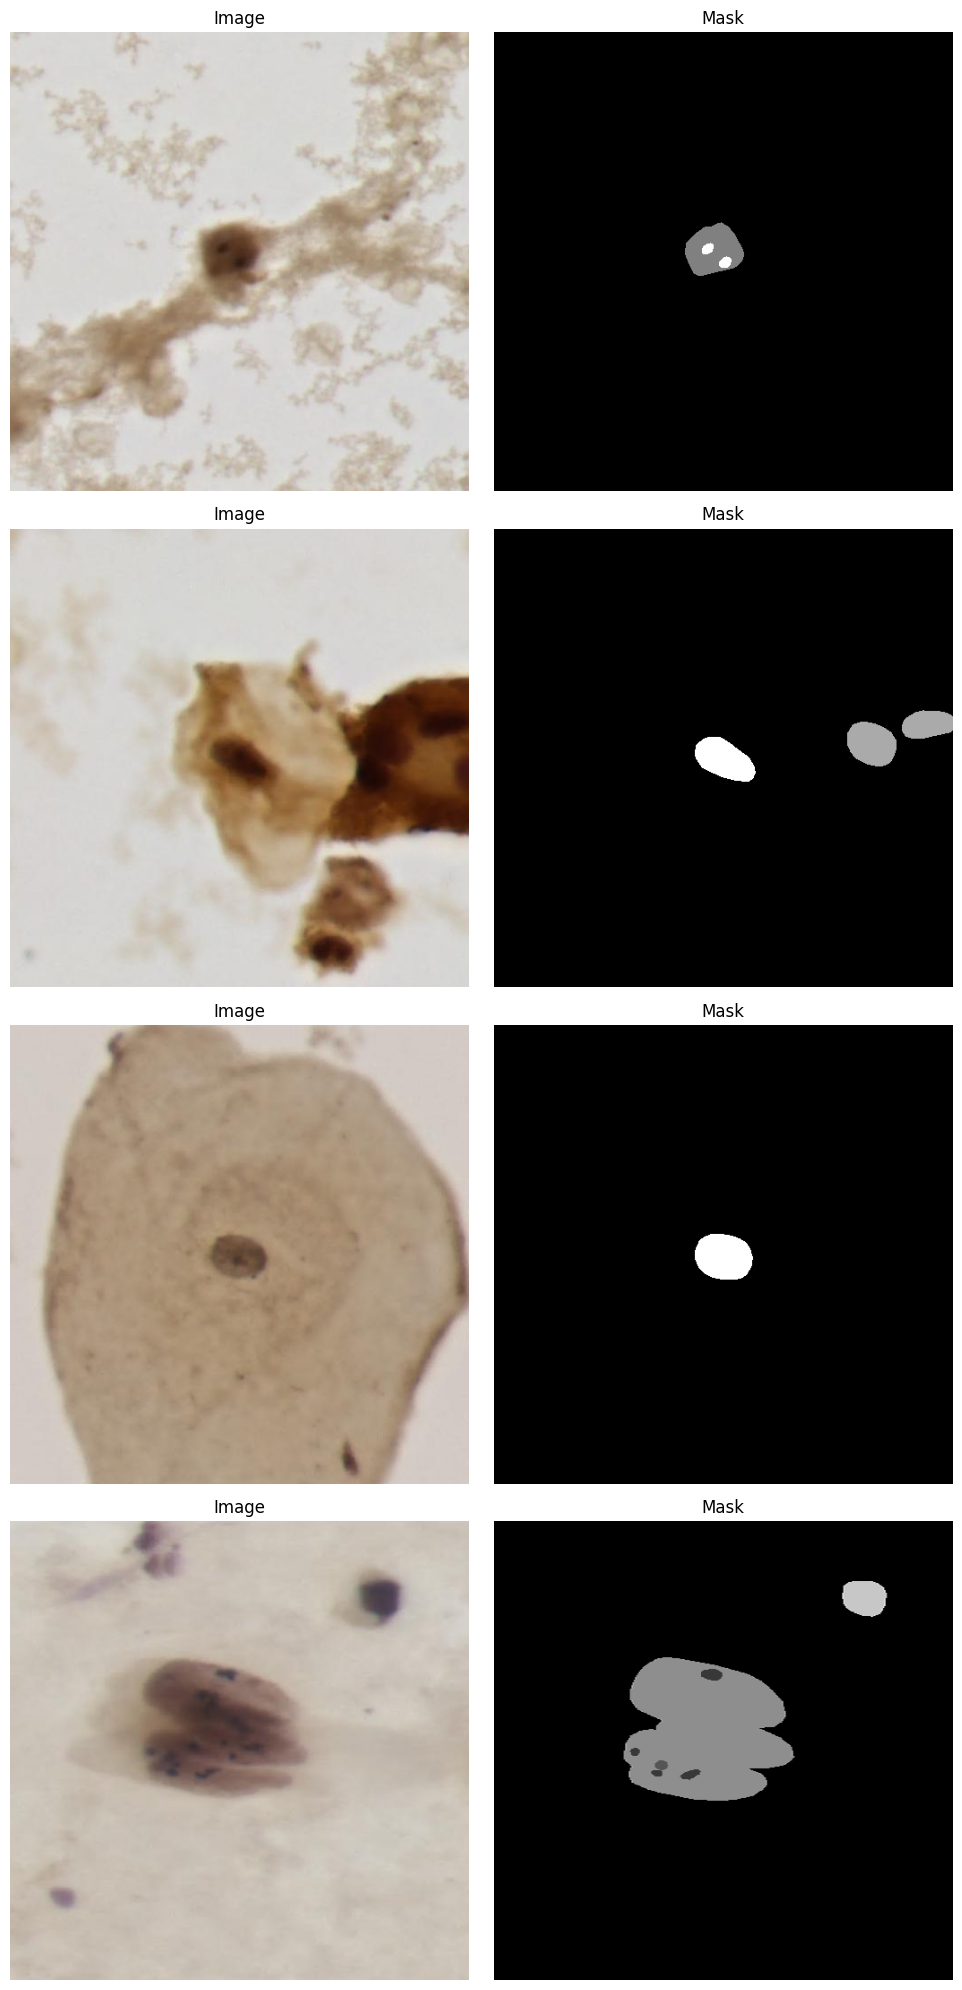

In [8]:
data_iter = iter(trainloader)
images, masks = next(data_iter)

num_samples = min(4, len(images))  # 至多顯示 4 張圖片

fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

for i in range(num_samples):
    # 取得單張影像和 mask
    image = images[i].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    mask = masks[i].numpy()                     # (H, W)
    
    # 視覺化影像
    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Image")
    axes[i, 0].axis("off")

    # 視覺化 mask
    axes[i, 1].imshow(mask, cmap="gray")
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [9]:
def contours_generate(input_img,fusion_img):
    input_img = np.float32(input_img)
    img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    img_gray *= 255
    colors = [(255,50,0),(131,60,11),(0,255,0),(0,0,255),(255,0,255),(255,0,0),(0,0,128)]
    for threshhold in range(1,8):
        ret, thresh = cv2.threshold(np.uint8(img_gray),(threshhold*36-1), 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(thresh, 3, 2)
        if contours:
            if threshhold == 1:
                hull = cv2.drawContours(fusion_img, contours, -1, colors[threshhold-2], 6)
            else:
                hull = cv2.drawContours(hull, contours, -1, colors[threshhold-2], 6)
        else :
            hull = fusion_img
    return hull

def vs_generate(input_mask, gen_mask, fusion):
    err_space = np.float64(np.logical_xor(input_mask, gen_mask))
    corr_space = np.logical_and(input_mask, gen_mask)
    R,G,B = cv2.split(err_space)
    R[R==0] = 0.18
    G[G==0] = 0.46
    G[G>0.47] = 0
    B[B==0] = 0.71
    B[B>0.72] = 0
    err_space =cv2.merge([R,G,B])
    
    err_space *= np.float64(np.logical_not(corr_space))
    corr_space = np.float64(corr_space)
    corr_space *= fusion
    err_space += corr_space
    return err_space

def compress_channel(input_batch_img, threshold):
    single_img = torch.zeros(1, input_batch_img.size(2), input_batch_img.size(3))
    output_batch_img = torch.zeros(input_batch_img.size(0), 1,
                                   input_batch_img.size(2), input_batch_img.size(3))
    for idx,n in enumerate(input_batch_img):
        for ch,img in enumerate(n):
            print("ch:",ch)
            print("img:",img)
            single_img[0][ img > threshold ] = ch
        output_batch_img[idx] = single_img
    return output_batch_img

def show_images(input_imgs, input_masks: None, gen_masks= None,
                nrow=5, ncol=1, show: bool = True, save: bool = False, path ="", mode: bool =False):
    # compare and show n*m images from generator in one figure and optionally save it
    if input_imgs.shape[0] < nrow:
        nrow = input_imgs.shape[0]
    figsize = (nrow*3+2,9)
    count = 311
    img_label = ["input\nimages", "input\nmask"]
    inputs = [input_imgs, input_masks]
    offset = -0.1

    if mode == True and gen_masks == None:
        print("Input ERROR! Expected [gen_mask] but got [None].")
        return None
        
    elif mode == True and gen_masks != None:
        figsize = (nrow*3+2,18)
        count = 611
        img_label.append("generated\nmask")
        inputs.append(gen_masks)

    plt.figure(figsize=figsize)
    for imgs, label in zip([imgs for imgs in inputs if input_masks is not None], img_label):
        print("Original imgs shape:", imgs.shape)  
        imgs = imgs[:nrow * ncol]                  # 按照行列截取
        if imgs.dim() == 3:  # 如果通道维度丢失
            imgs = imgs.unsqueeze(1)
        print("Adjusted imgs shape:", imgs.shape) 
        imgs = imgs.view(imgs.size(0), imgs.size(1), 512, 512)
        ax = plt.subplot(count)
        ax.set_title(label ,x=offset, y=0.35)
        img = np.transpose(make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0))
        img = np.float32(np.array(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img.shape[1]*2, int(img.shape[0]*1.5)), interpolation=cv2.INTER_AREA)
        plt.axis("off")
        plt.imshow(img)

        if label == "input\nmask":
            input_mask = img
        if label == "generated\nmask":
            gen_mask = img

        if label == "input\nimages":
            origin_img = img/3+0.6
        else :
            count+=1
            ax = plt.subplot(count)
            name = label.split("\n")[0] + "\nfusion"
            ax.set_title(name,x=offset, y=0.35)
            fusion = origin_img.copy()
            contours_generate(img,fusion)
            plt.axis("off")
            plt.imshow(fusion)
        
        if label == "generated\nmask":
            count+=1
            ax = plt.subplot(count)
            name = "ground truth\nvs\ngenerated"
            ax.set_title(name,x=offset, y=0.35)
            fusion = origin_img.copy()
            vs = vs_generate(input_mask, gen_mask, fusion)
            #print(vs,)
            plt.axis("off")
            plt.imshow(vs)
        count+=1
    if save:
        plt.savefig('./show.png')
    if show:
        plt.show()

image shape: torch.Size([24, 3, 512, 512])
mask shape torch.Size([24, 1, 512, 512])
Original imgs shape: torch.Size([24, 3, 512, 512])
Adjusted imgs shape: torch.Size([5, 3, 512, 512])
Original imgs shape: torch.Size([24, 1, 512, 512])
Adjusted imgs shape: torch.Size([5, 1, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


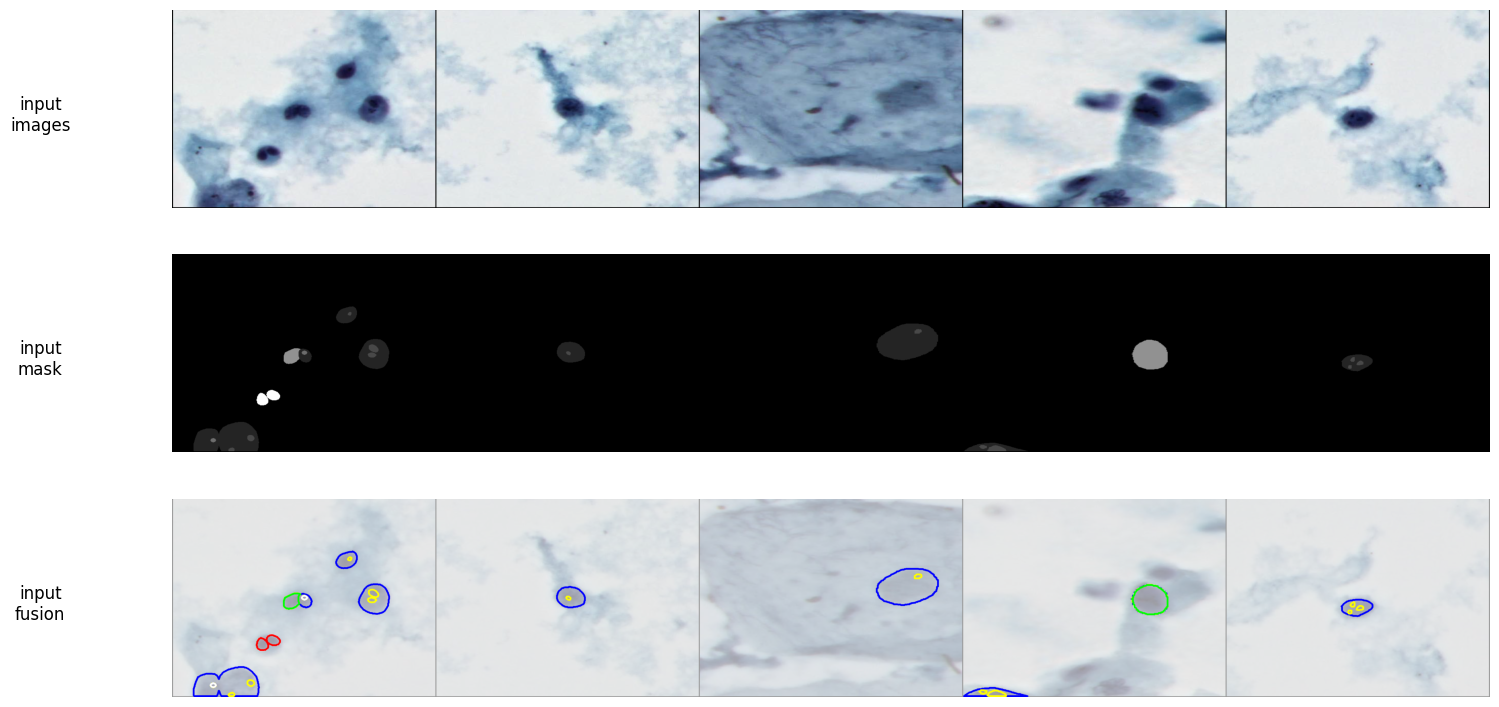

In [10]:
images, masks = next(iter(trainloader))

images = images.cpu()
masks = masks.cpu()

masks = masks.unsqueeze(1)
print("image shape:",images.shape) 
print("mask shape",masks.shape)   

show_images(
    input_imgs=images,   
    input_masks=masks.float(),    
    gen_masks=None,       # 如果没有生成的 mask，传 None
    nrow=5,               
    ncol=1,               
    show=True,            
    save=False,           
    path="",              
    mode=False            # 是否显示生成的 mask 对比
)

## Unet

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )


## Training

In [12]:
# 測試輸入
dummy_input = torch.randn(4, 3, 512, 512).to(device)  # 假設 batch_size=4, in_channels=3
model = UNet(in_channels=3, out_channels=7).to(device)

# 測試輸出
output = model(dummy_input)
print(output.shape)  # 應輸出 torch.Size([4, 8, 512, 512])

torch.Size([4, 7, 512, 512])


In [13]:
import sched

n_channels = 3
n_classes = 8

unet = UNet(in_channels = n_channels, out_channels = n_classes).to(device)
optimizer = optim.Adam(unet.parameters(), lr = LR)
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)
criterion = nn.CrossEntropyLoss() 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

/tmp/ipykernel_2835276/3605282396.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler(enabled=True)


In [ ]:
train_loss = []
val_loss = []
loss_prev = 10
for epoch in (range(EPOCHS)):
    unet.train()  
    epoch_loss = 0
    i_bar = tqdm(trainloader, unit='iter', desc=f'epoch{epoch}')
    for (imgs, masks) in i_bar:
        masks = torch.clamp(masks, 0, n_classes - 1)
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            pred = unet(imgs)
            loss = criterion(pred, masks)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        train_loss.append(loss.item())
        epoch_loss += loss.item()
        i_bar.set_postfix(loss=loss.item())
    scheduler.step()
    """
    val
    """
    with torch.no_grad():
        unet.eval()  
        
        val_epoch_loss = 0
        val_count = 0
        
        for (imgs, masks) in valloader:
            masks = torch.clamp(masks, 0, n_classes - 1)
            imgs, masks = imgs.to(device), masks.to(device)
            pred = unet(imgs) 
            loss = criterion(pred, masks)  
            val_epoch_loss += loss.item()  
            val_count += 1

        val_loss_avg = val_epoch_loss / val_count
        val_loss.append(val_loss_avg) 
        print(f"Train Loss: {epoch_loss / len(trainloader):.4f}, Validation Loss: {val_loss_avg:.4f}")
    
    if val_loss_avg < loss_prev:
        loss_prev = val_loss_avg
        torch.save(unet.state_dict(), 'best_model.pth') 
        print("Saved best model!")
    
    print("----------------------------------------------")

epoch0:   0%|          | 0/612 [00:00<?, ?iter/s]/tmp/ipykernel_2835276/943603360.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
epoch0: 100%|██████████| 612/612 [03:27<00:00,  2.95iter/s, loss=0.795]


Train Loss: 1.3598, Validation Loss: 0.7987
Saved best model!
----------------------------------------------


epoch1:  39%|███▉      | 241/612 [01:21<02:05,  2.97iter/s, loss=0.549]

In [ ]:
from torch import long

imgs, masks = next(iter(testloader))
unet.load_state_dict(torch.load('best_model.pth'))
masks_pred = unet(imgs.to(device))

probs = torch.softmax(masks_pred, dim=1)
pred_labels = torch.argmax(probs, dim=1) 
pred_labels = pred_labels.unsqueeze(1) 

/tmp/ipykernel_4011221/2262983289.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load('best_model.pth'))


In [ ]:
print(pred_labels.shape)   # 應該是 (batch_size, H, W)
print(pred_labels.dtype) 

torch.Size([24, 1, 512, 512])
torch.int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Original imgs shape: torch.Size([24, 3, 512, 512])
Adjusted imgs shape: torch.Size([5, 3, 512, 512])
Original imgs shape: torch.Size([24, 512, 512])
Adjusted imgs shape: torch.Size([5, 1, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Original imgs shape: torch.Size([24, 1, 512, 512])
Adjusted imgs shape: torch.Size([5, 1, 512, 512])


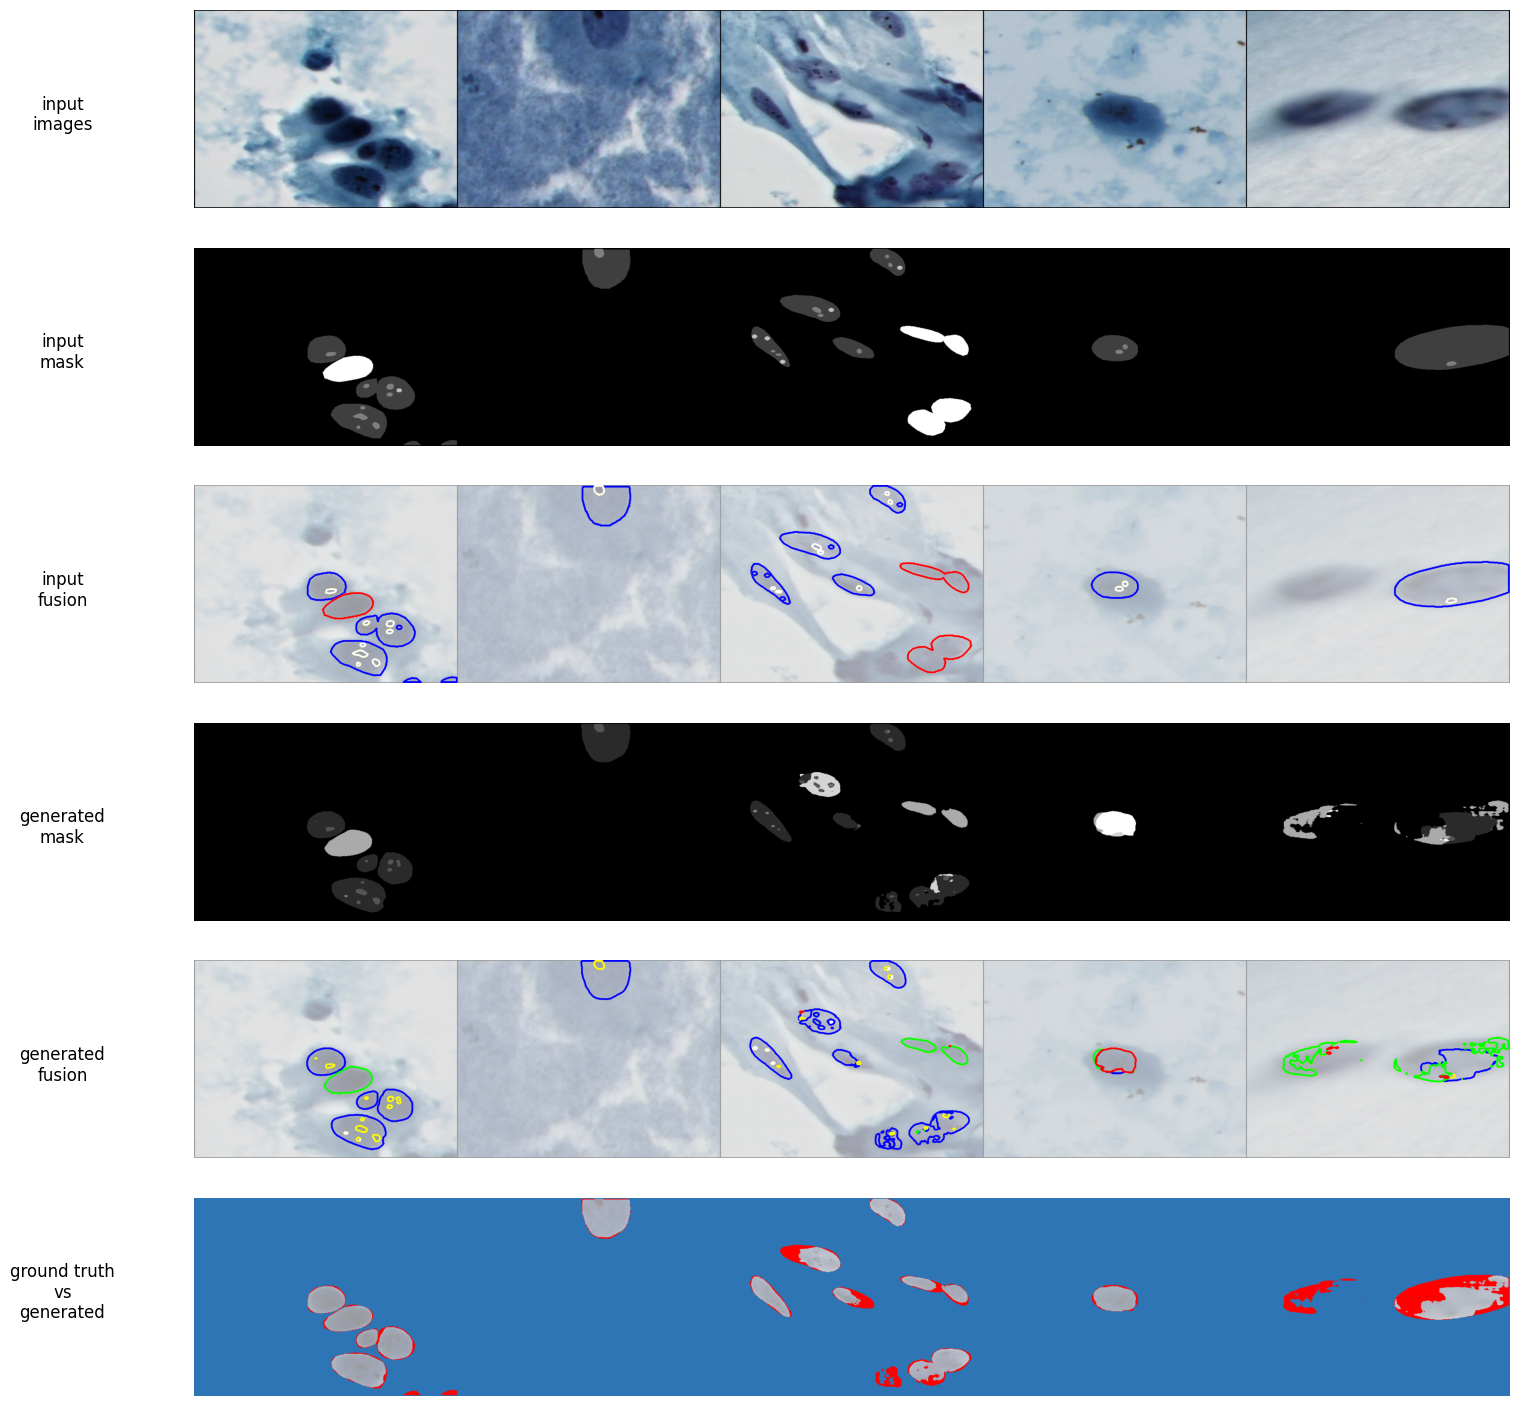

In [ ]:
show_images(
    input_imgs=imgs,   
    input_masks=masks.float(),  
    gen_masks=pred_labels.float(),       
    nrow=5,               
    ncol=1,              
    show=True,            
    save=False,           
    path="",              # 保存路径（如果 save=True）
    mode=True             # 是否显示生成的 mask 对比
)

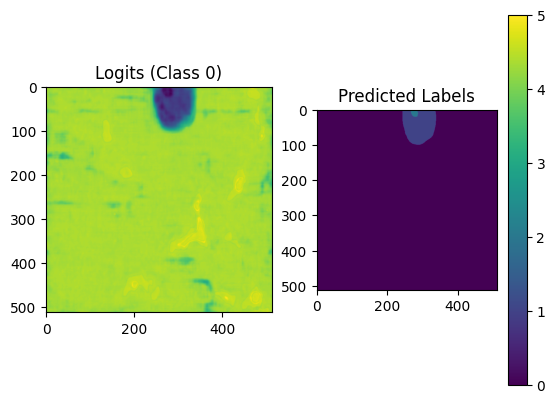

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Logits (Class 0)")
plt.imshow(masks_pred[1, 0].detach().cpu())  # 第 0 类的 logits

plt.subplot(1, 2, 2)
plt.title("Predicted Labels")
plt.imshow(pred_labels[1].detach().cpu())  # 预测标签

plt.colorbar()
plt.show()